Using TensorFlow backend.


len steer 8036
-0.9426954: 2
-0.9332381: 1
-0.9237437: 1
-0.8098114: 1
-0.771834: 1
-0.7243622: 1
-0.6863848: 2
-0.6294187: 2
-0.6009356: 2
-0.5344751: 1
-0.5249807: 2
-0.505992: 8
-0.4964977: 6
-0.4775089: 1
-0.4680146: 2
-0.4585202: 1
-0.4490258: 17
-0.4395315: 12
-0.4300371: 1
-0.4205428: 4
-0.4110484: 15
-0.401554: 3
-0.3920597: 10
-0.3825653: 8
-0.373071: 10
-0.3540823: 9
-0.3445879: 4
-0.3350936: 5
-0.3255992: 9
-0.3161048: 14
-0.3066105: 9
-0.2971161: 43
-0.2876218: 38
-0.2781274: 31
-0.2686331: 18
-0.2591387: 10
-0.2496443: 11
-0.24015: 9
-0.2306556: 36
-0.2211613: 41
-0.2116669: 56
-0.2021725: 7
-0.1926782: 8
-0.1831838: 16
-0.1736895: 20
-0.1641951: 36
-0.1547008: 49
-0.1452064: 179
-0.135712: 51
-0.1262177: 26
-0.1167233: 55
-0.107229: 33
-0.09773462: 23
-0.08824026: 80
-0.0787459: 150
-0.06925154: 129
-0.05975719: 152
-0.05026283: 61
-0.04076847: 46
-0.03127411: 38
-0.02177976: 49
-0.0122854: 31
-0.002791043: 79
0.0: 4361
0.004348711: 12
0.01391724: 74
0.02348577: 53
0.0330

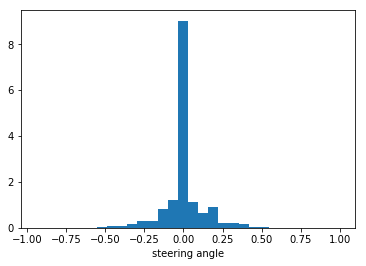

In [1]:
import csv
import cv2
import keras
import numpy as np
import sklearn

from keras.models import Sequential
from keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D
from keras.callbacks import History 


k_prob =0.25
EPOCHS = 2
BATCH_SIZE = 16
VALID_SIZE_RATIO = 0.1
TEST = 0
LOAD = 0
LOAD_MODEL = 'model_nvidia_lin_e2.h5'
SAVE_MODEL = 'model_nvidia_prep_lin_test1.h5'


history = History()

samples_00 = []  # samples of steering angle         n == 0
samples_02 = []  # samples of steering angle     0 < n <= 0.25
samples_12 = []  # samples of steering angle -0.25 < n <= 0
samples_99 = []  # samples of steering angle outside of the above
steer      = []  # 
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(line[0] == 'center'):
            print("skipping line:", line)
        else:
            if(float(line[3]) == 0):
                samples_00.append(line)
            elif(float(line[3]) > 0 and float(line[3]) <= 0.25):
                samples_02.append(line)
            elif(float(line[3]) < 0 and float(line[3]) >= -0.25):
                samples_12.append(line)
            else:
                samples_99.append(line)
            steer.append(float(line[3]))

u_steer, u_cnt = np.unique(steer, return_counts=True)
print("len steer", len(steer))
print(*(map('{}: {}'.format, u_steer, u_cnt)), sep="\n")

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(steer, normed=True, bins=30)
plt.xlabel('steering angle');

print("len samples_00", len(samples_00))
print("len samples_02", len(samples_02))
print("len samples_12", len(samples_12))
print("len samples_99", len(samples_99))

len bal_samples_00 130
len bal_samples_02 313
len bal_samples_12 279
len     samples_99 636
len samples 1358


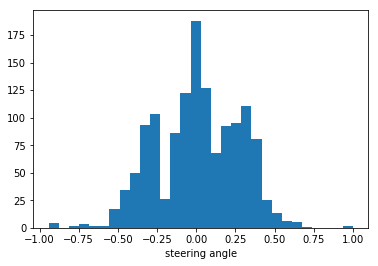

In [2]:
import random
from random import shuffle

def down_sample_size(samples, target_size):
    random.shuffle(samples)
    return samples[0:target_size]

DROP_ZERO_RATIO = 0.97  #0.98
DROP_PT_2_RATIO = 0.80  #0.75
DROP_PTN2_RATIO = 0.81  #0.76

bal_samples_00 = down_sample_size(samples_00, int(len(samples_00)*(1-DROP_ZERO_RATIO)))
bal_samples_02 = down_sample_size(samples_02, int(len(samples_02)*(1-DROP_PT_2_RATIO)))
bal_samples_12 = down_sample_size(samples_12, int(len(samples_12)*(1-DROP_PTN2_RATIO)))

print("len bal_samples_00", len(bal_samples_00))
print("len bal_samples_02", len(bal_samples_02))
print("len bal_samples_12", len(bal_samples_12))
print("len     samples_99", len(samples_99))

samples = []
for sam in bal_samples_00:
    samples.append(sam)
for sam in bal_samples_02:
    samples.append(sam)
for sam in bal_samples_12:
    samples.append(sam)
for sam in samples_99:
    samples.append(sam)

random.shuffle(samples)
print("len samples", len(samples))

steer = []
for line in samples:
    steer.append(float(line[3]))

plt.hist(steer, normed=False, bins=30)
plt.xlabel('steering angle');

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=VALID_SIZE_RATIO)

def generator(samples, batch_size=32, validation=False):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                #processing center image
                name = 'data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                images.append(center_image)
                
                #processing steering angle
                center_angle = float(batch_sample[3])
                angles.append(center_angle)
                
                #processing flipped center image
                flip_image = cv2.flip(center_image, 1)
                #flip center image and invert steering angle by multiply by -1
                images.append(flip_image)
                angles.append(center_angle*-1.0)

                # if this is for validation data samples, don't include the manipulated data below
                if(validation == False):
                    #manipulate images to increase data sample for training
                    #processing lef image
                    name = 'data/IMG/'+batch_sample[1].split('/')[-1]
                    left_image = cv2.imread(name)
                    #add left image and add a random positive correction factor to steering to left
                    images.append(left_image)
                    angles.append(center_angle+0.25)
                    #angles.append(center_angle+((1-abs(center_angle))*0.25))
                    
                    #processing right image
                    name = 'data/IMG/'+batch_sample[2].split('/')[-1]
                    right_image = cv2.imread(name)
                    #add right image and add a random negative correction factor to steering to right
                    images.append(right_image)
                    angles.append(center_angle-0.25)
                    #angles.append(center_angle-((1-abs(center_angle))*0.25))

            X_data = np.array(images)
            y_data = np.array(angles)
            
            if(TEST==1):
                plt.hist(angles, normed=False, bins=30)
                plt.xlabel('steering angle');

                #print("X_data",X_data.shape)
                #print("y_data",y_data.shape)
                #print("X_data",X_data[:2])
                #print("y_data",y_data[:30])

            #return X and y dataset of batch size
            yield sklearn.utils.shuffle(X_data, y_data)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)




print("Building a Keras Model")

#loading a previously trained model
if (LOAD==1):
    model = keras.models.load_model(LOAD_MODEL)

#starting a model for training
else:
    #instantiating a Keras Sequential Model
    model = Sequential()
    
    #crop out top and bottom pixels to reduce noise from sky and hood
    model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))

    #normalizing input data
    model.add(Lambda(lambda x: (x/255.0)-0.5))

    #for testing initial model bring up only
    if(TEST==1):
        #model.add(Flatten())  # size of 2496
        #model.add(Dense(1))
        print("skip model")
    else:
        model.add(Conv2D(16, kernel_size=(5,5), strides=(2,2), activation='relu')) # 45x320x3  -> 41x316x24 -> 20x158x24
        model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu')) # 20x158x24 -> 16x154x36 -> 8x77x36
        model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu')) # 8x77x36   -> 6x73x48   -> 3x36x48
        model.add(Dropout(k_prob))
        model.add(Conv2D(48, kernel_size=(3,3), activation='relu')) # 3x36x48   -> 1x34x48
        model.add(Dropout(k_prob))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu')) # 
        model.add(Dropout(k_prob))
        model.add(Flatten())  # size of 2496
        model.add(Dense(256))
        model.add(Dropout(k_prob))
        model.add(Dense(100))
        model.add(Dropout(k_prob))
        model.add(Dense(10))
        model.add(Dropout(k_prob))
        model.add(Dense(1)) #adding softmax activation at the last layer seems to cause steering stuck at 1 or right turn

    model.compile(loss='mse', 
                  optimizer='adam')

print("Fitting model with generators")
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_samples), 
                                     validation_data=validation_generator,
                                     validation_steps=len(validation_samples), 
                                     epochs=EPOCHS,
                                     callbacks=[history],
                                     verbose=1)

print("Save model")
model.save(SAVE_MODEL)
print("Written to ", SAVE_MODEL)

Building a Keras Model
Fitting model with generators
Epoch 1/2
1222/1222 [==============================] - 829s 679ms/step - loss: 0.0391 - val_loss: 0.0361
Epoch 2/2
1222/1222 [==============================] - 829s 678ms/step - loss: 0.0274 - val_loss: 0.0372
Save model
Written to  model_nvidia_prep_lin_test1.h5


dict_keys(['loss', 'val_loss'])


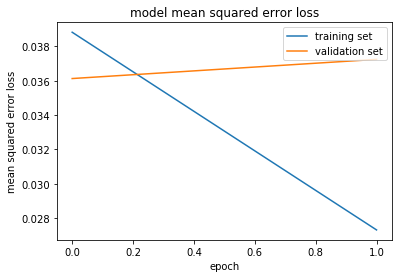

In [4]:
### print the keys contained in the history object
print(history_object.history.keys())
print(history_object)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()